# Stokes equation

Authors: J.S. Dokken, M.W. Scroggs, S. Roggendorf

In 

Import some stuff

In [1]:
from dolfinx import fem, mesh
from ufl import (VectorElement, EnrichedElement, FiniteElement,
                 SpatialCoordinate, TrialFunction, TestFunction,
                 as_vector, cos, sin, inner, div, grad, dx, pi)
import numpy as np
from petsc4py import PETSc
from mpi4py import MPI
import basix
import basix.ufl_wrapper

import matplotlib.pylab as plt

## Defining a Stokes solver

TODO: some text here, probably split this code into multiple cells.

In [9]:
def u_ex(x):
    sinx = sin(pi * x[0]) 
    siny = sin(pi * x[1])
    cosx = cos(pi * x[0])
    cosy = cos(pi * x[1])
    c_factor = 2 * pi * sinx * siny
    return c_factor * as_vector((cosy * sinx, - cosx * siny))

def p_ex(x):
    return sin(2 * pi * x[0]) * sin(2 * pi * x[1])

def source(x):
    u, p = u_ex(x), p_ex(x)
    return - div(grad(u)) + grad(p)

def assemble_scalar(J, comm: MPI.Comm):
    scalar_form = fem.form(J)
    local_J = fem.assemble_scalar(scalar_form)
    return comm.allreduce(local_J, op=MPI.SUM)


def solve_stokes(u_element, p_element, domain):
    V = fem.FunctionSpace(domain, u_element)
    Q = fem.FunctionSpace(domain, p_element)

    
    # Velocity boundary condition
    g = fem.Function(V)
    g.x.set(0.0)
    tdim = domain.topology.dim
    domain.topology.create_connectivity(tdim - 1, tdim)
    bdry_facets = mesh.exterior_facet_indices(domain.topology)
    dofs = fem.locate_dofs_topological(V, tdim - 1, bdry_facets)
    bcv = fem.dirichletbc(g, dofs)
    bcs = [bcv]

    # Define variational problem
    u, p = TrialFunction(V), TrialFunction(Q)
    v, q = TestFunction(V), TestFunction(Q)
    x = SpatialCoordinate(domain)
    f = source(x)
    a_00 = inner(grad(u), grad(v)) * dx
    a_01 = - inner(p, div(v)) * dx
    a_10 = - inner(div(u), q) * dx
    a = fem.form([[a_00, a_01],
                  [a_10, None]])
    rhs_form = fem.form([inner(f, v) * dx,
                  inner(fem.Constant(domain, 0.), q) * dx])
    lhs_form = fem.form(a)



    # Assemble LHS matrix and RHS vector
    A = fem.petsc.assemble_matrix_nest(lhs_form, bcs=bcs)
    A.assemble()

    # We create a nested matrix `P` to use as the preconditioner. The
    # top-left block of `P` is shared with the top-left block of `A`. The
    # bottom-right diagonal entry is assembled from the form `a_p11`:

        # We will use a block-diagonal preconditioner to solve this problem:
    a_p11 = fem.form(inner(p, q) * dx)
    a_p = [[a[0][0], None],
           [None, a_p11]]
    
    P11 = fem.petsc.assemble_matrix(a_p11, [])
    P = PETSc.Mat().createNest([[A.getNestSubMatrix(0, 0), None], [None, P11]])
    P.assemble()
    b = fem.petsc.assemble_vector_nest(rhs_form)
    fem.petsc.apply_lifting_nest(b, a, bcs=bcs)

    # Sum contributions from ghost entries on the owner
    for b_sub in b.getNestSubVecs():
        b_sub.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)

    # Set Dirichlet boundary condition values in the RHS
    bcs0 = fem.bcs_by_block(fem.extract_function_spaces(rhs_form), bcs)
    fem.petsc.set_bc_nest(b, bcs0)

    # Create nullspace vector
    null_vec = fem.petsc.create_vector_nest(rhs_form)

    # Set velocity part to zero and the pressure part to a non-zero constant
    null_vecs = null_vec.getNestSubVecs()
    null_vecs[0].set(0.0), null_vecs[1].set(1.0)

    # Normalize the vector, create a nullspace object, and attach it to the
    # matrix
    null_vec.normalize()
    nsp = PETSc.NullSpace().create(vectors=[null_vec])
    assert nsp.test(A)
    A.setNullSpace(nsp)
  
    # Now we create a Krylov Subspace Solver `ksp`. We configure it to use
    # the MINRES method, and a block-diagonal preconditioner using PETSc's
    # additive fieldsplit type preconditioner:

    # +
    ksp = PETSc.KSP().create(domain.comm)
    ksp.setOperators(A, P)
    ksp.setType("minres")
    ksp.setTolerances(rtol=1e-9)
    ksp.getPC().setType("fieldsplit")
    ksp.getPC().setFieldSplitType(PETSc.PC.CompositeType.ADDITIVE)

    # Define the matrix blocks in the preconditioner with the velocity and
    # pressure matrix index sets
    nested_IS = P.getNestISs()
    ksp.getPC().setFieldSplitIS(
        ("u", nested_IS[0][0]),
        ("p", nested_IS[0][1]))

    # Set the preconditioners for each block
    ksp_u, ksp_p = ksp.getPC().getFieldSplitSubKSP()
    ksp_u.setType("preonly")
    ksp_u.getPC().setType("gamg")
    ksp_p.setType("preonly")
    ksp_p.getPC().setType("jacobi")
    ksp.setFromOptions()

    # Compute the solution
    u = fem.Function(V)
    p = fem.Function(Q)
    w = PETSc.Vec().createNest([u.vector, p.vector])
    ksp.solve(b, w)
    assert ksp.getConvergedReason() > 0
    u.x.scatter_forward()
    p.x.scatter_forward()

    # Error computation
    error_u = u - u_ex(x)
    H1_u = inner(error_u, error_u) * dx + inner(grad(error_u), grad(error_u)) * dx
    velocity_error = np.sqrt(assemble_scalar(H1_u, domain.comm))
    error_p = p - p_ex(x)
    L2_p = fem.form(error_p * error_p * dx)
    pressure_error = np.sqrt(assemble_scalar(L2_p, domain.comm))
    return velocity_error, pressure_error

TODO: some text here

In [10]:
def compute_errors(element_u, element_p, refinments=5):
    N0 = 7
    hs = np.zeros(nmeshes)
    u_errors = np.zeros(nmeshes)
    p_errors = np.zeros(nmeshes)
    comm = MPI.COMM_WORLD
    for i in range(refinements):
        # This works
        N = N0 * 2**i
        domain = mesh.create_unit_square(comm, N, N, 
                                         cell_type=mesh.CellType.triangle)
        u_errors[i] , p_errors[i] = solve_stokes(element_u, element_p, domain)
        hs[i] = 1. / N
    return hs, u_errors, p_errors

## The elements

We now use the Stokes solver we have defined to experiment with a range of element pairs that can be used. First, we define a function that takes an element as input and plots a graph showing the error as $h$ is decreased.

In [11]:
def error_plot(element_u, element_p, convergence=None, nmeshes=5):
    hs, v_errors, p_errors = compute_errors(element_u, element_p, nmeshes)

    legend = []
    if convergence is not None:
        y_value = v_errors[-1] * 1.4
        plt.plot([hs[0], hs[-1]], [y_value * (hs[0] / hs[-1])**convergence, y_value], "k--")
        legend.append(f"order {convergence}")
    print(hs, v_errors, p_errors)
    plt.plot(hs, v_errors, "bo-")
    plt.plot(hs, p_errors, "ro-")
    legend += ["velocity", "pressure"]
    plt.legend(legend)
    plt.xscale("log")
    plt.yscale("log")
    plt.axis("equal")
    plt.ylabel("Error in energy norm")
    plt.xlabel("$h$")
    plt.xlim(plt.xlim()[::-1])
    plt.grid(True)

## Piecewise constant pressure spaces

For our first element, we pair piecewise linear elements with piecewise constants.

<img src='./img/element-Lagrange-triangle-1-dofs-large.png' style='width:100px' /><img src='./img/element-Lagrange-triangle-0-dofs-large.png' style='width:100px' />

Using these elements, we do not converge to the solution.

[0.14285714 0.07142857 0.03571429 0.01785714 0.00892857] [14.08968714 14.08968714 14.08968714 14.08968714 14.08968714] [  79.92400619  164.81112685  332.14283128  665.55123932 1331.73593983]


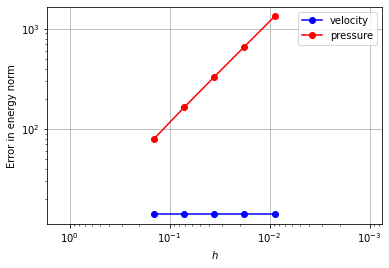

In [13]:
element_u = VectorElement("Lagrange", "triangle", 1)
element_p = FiniteElement("DG", "triangle", 0)
error_plot(element_u, element_p)

One way to obtain convergence with a piecewise constant pressure space is to use a piecewise quadratic space for the velocity (Fortin, 1972).

<img src='./img/element-Lagrange-triangle-2-dofs-large.png' style='width:100px' /><img src='./img/element-Lagrange-triangle-0-dofs-large.png' style='width:100px' />

[0.14285714 0.07142857 0.03571429 0.01785714 0.00892857] [0.80737519 0.21906002 0.064031   0.02278226 0.00989817] [0.14836316 0.07470491 0.0374005  0.01870138 0.00935036]


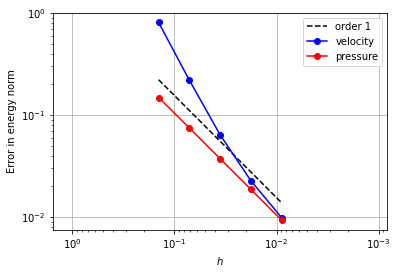

In [14]:
element_u = VectorElement("Lagrange", "triangle", 2)
element_p = FiniteElement("DG", "triangle", 0)
error_plot(element_u, element_p, 1)

Alternatively, the same order convergence can be achieved using fewer degrees of freedom if a Crouzeix-Raviart element is used for the velocity space (Crouziex, Raviart, 1973).

<img src='./img/element-Crouzeix-Raviart-triangle-1-dofs-large.png' style='width:100px' /><img src='./img/element-Lagrange-triangle-0-dofs-large.png' style='width:100px' />

In [ ]:
element_u = VectorElement("CR", "triangle", 1)
element_p = FiniteElement("DG", "triangle", 0)
error_plot(element_u, element_p, 1)

## Piecewise linear pressure space

When using a piecewise linear pressure space, we could again try using a velocity space one degree higher, but we would again observe that there is no convergence. In order to achieve convergence, we can augment the quadratic space with a cubic bubble function on the triangle (Crouziex, Falk, 1988).

<img src='./img/element-bubble-enriched-Lagrange-triangle-2-dofs-large.png' style='width:100px' /><img src='./img/element-Lagrange-triangle-1-dofs-large.png' style='width:100px' />

In [ ]:
enriched_element = FiniteElement("Lagrange", "triangle", 2) + FiniteElement("Bubble", "triangle", 3)
element_u = VectorElement(enriched_element)
element_p = FiniteElement("DG", "triangle", 1)
error_plot(element_u, element_p, 2)

## Piecewise quadratic pressure space

When using a piecewise quadratic space, we can use a cubic velocity space augmented with quartic bubbles (Crouzeix, Falk, 1988).

<img src='./img/element-bubble-enriched-Lagrange-triangle-3-dofs-large.png' style='width:100px' /><img src='./img/element-Lagrange-triangle-2-dofs-large.png' style='width:100px' />

We have to define this velocity element as a custom element (it cannot be created as an enriched element, as the basis functions of degree 3 Lagrange and degree 4 bubbles are not linearly independent). More examples of how custom elements can be created can be found [in the Basix documentation](https://docs.fenicsproject.org/basix/v0.5.0/python/demo/demo_custom_element.py.html).

### Defining the polynomial space

When creating a custom element, we must input the coefficients that define a basis of the set of polynomials that our element spans. In this example, we will represent the 9 functions in our space in terms of the 10 orthonormal polynomials of degree $\leqslant3$ on a quadrilateral, so we create a 9 by 10 matrix.

A polynomial $f$ on the triangle can be written as
$$f(x,y)=\sum_i\left(\int_0^1\int_0^{1-y}f(x, y)q_i(x, y) \,\mathrm{d}x\,\mathrm{d}y\right)q_i(x,y),$$
where $q_0$, $q_1$, ... are the orthonormal polynomials. The entries of our coefficient matrix are these integrals.

In [ ]:
wcoeffs = np.zeros((12, 15))
pts, wts = basix.make_quadrature(basix.CellType.triangle, 8)
poly = basix.tabulate_polynomials(basix.PolynomialType.legendre, basix.CellType.triangle, 4, pts)
x = pts[:, 0]
y = pts[:, 1]
for j, f in enumerate([
    1, x, y, x**2*y, x*y**2, (1-x-y)**2*y, (1-x-y)*y**2, x**2*(1-x-y), x*(1-x-y)**2,
    x*y*(1-x-y), x**2*y*(1-x-y), x*y**2*(1-x-y)
]):
    for i in range(15):
        wcoeffs[j, i] = sum(f * poly[i, :] * wts)

### Interpolation

Next, we compute the points and matrices that define how functions can be interpolated into this space. For this element, all the DOFs are point evaluations, so we create lists of these points and (reshaped) identity matrices.

In [ ]:
x = [[], [], [], []]
x[0].append(np.array([[0.0, 0.0]]))
x[0].append(np.array([[1.0, 0.0]]))
x[0].append(np.array([[0.0, 1.0]]))
x[1].append(np.array([[2 / 3, 1 / 3], [1 / 3, 2 / 3]]))
x[1].append(np.array([[0.0, 1 / 3], [0.0, 2 / 3]]))
x[1].append(np.array([[1 / 3, 0.0], [2 / 3, 0.0]]))
x[2].append(np.array([[1 / 4, 1 / 4], [1 / 2, 1 / 4], [1 / 4, 1 / 2]]))

M = [[], [], [], []]
for _ in range(3):
    M[0].append(np.array([[[[1.]]]]))
for _ in range(3):
    M[1].append(np.array([[[[1.], [0.]]], [[[0.], [1.]]]]))
M[2].append(np.array([[[[1.], [0.], [0.]]], [[[0.], [1.], [0.]]], [[[0.], [0.], [1.]]]]))

### Creating the element

We now create the element by passing in the information we created above, as well as the cell type, value shape, number of derivatives used by the DOFs, map type, whether the element is discontinuous, the highest degree Lagrange space that is a subspace of the element, and the polynomial degree of the element.

In [ ]:
p3_plus_bubbles = basix.ufl_wrapper.BasixElement(basix.create_custom_element(
    basix.CellType.triangle, [], wcoeffs, x, M, 0, basix.MapType.identity, False, 3, 4))
element_u = VectorElement(p3_plus_bubbles)
element_p = FiniteElement("DG", "triangle", 2)
error_plot(element_u, element_p, 3, 4)

## References

Crouzeix, Michel and Falk, Richard S. Nonconforming finite elements for the Stokes problem, *Mathematics of Computation* 52, 437–456, 1989. [DOI: [10.2307/2008475](https://doi.org/10.2307/2008475)]

Crouzeix, Michel and Raviart, Pierre-Arnaud. Conforming and nonconforming finite element methods for solving the stationary Stokes equations, *Revue Française d'Automatique, Informatique et Recherche Opérationnelle* 3, 33–75, 1973. [DOI: [10.1051/m2an/197307R300331](https://doi.org/10.1051/m2an/197307R300331)]

Fortin, Michel. Calcul numérique des écoulements des fluides de Bingham et des fluides newtoniens incompressibles par la méthode des éléments finis (PhD thesis), Univ. Paris, 1972.

The images of elements used in this example were taken from DefElement:<br />
The DefElement contributors. DefElement: an encyclopedia of finite element definitions, 2022, https://defelement.com [Online; accessed: 15-August-2022].